In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from tbats import TBATS
import matplotlib.dates as mdates
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import mlflow.pyfunc.model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import os 

## data preparation

In [2]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + "april_data_processed.csv"

In [3]:
df_april = pd.read_csv(modified_path, index_col=[0]) 
df_april.Date = pd.to_datetime(df_april['Date'])
df_april.index = pd.to_datetime(df_april.index)

# Experiments

In [4]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "models\\Tracking"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string
modified_path = f"file:///" + modified_path 

In [5]:
tracking_uri = modified_path
mlflow.set_tracking_uri(modified_path)
# Create a named experiment
mlflow.set_experiment("experiments_in_april_final")
experiment = mlflow.get_experiment_by_name("experiments_in_april_final")

2023/09/27 12:41:33 INFO mlflow.tracking.fluent: Experiment with name 'experiments_in_april_final' does not exist. Creating a new experiment.


## plotting the data

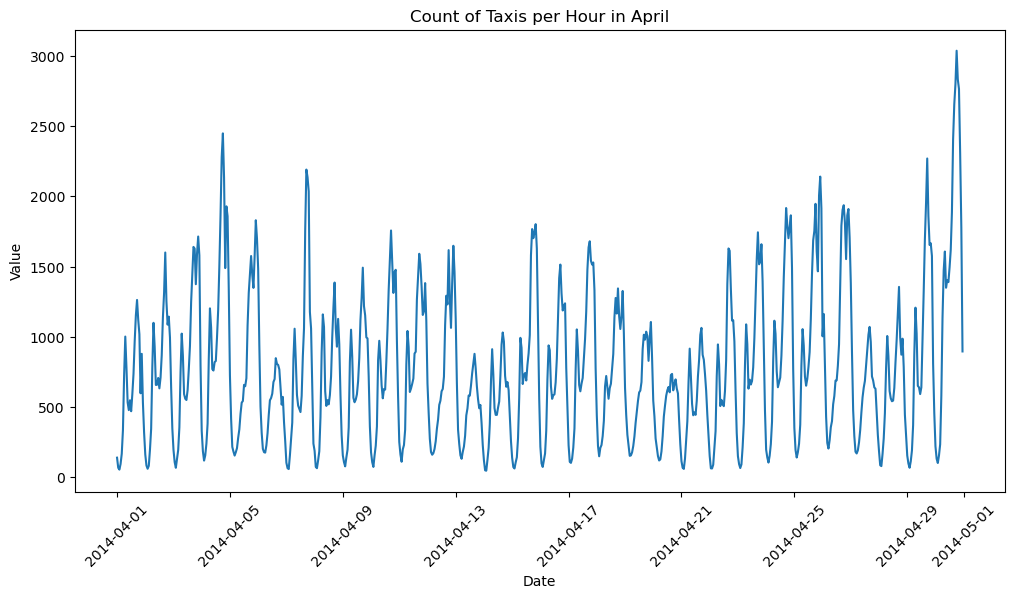

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_april["Count"])

# Rotate the x-axis date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Count of Taxis per Hour in April")

plt.show()

## Checking periodicites with periodogram

[23.999999999999996,
 11.999999999999998,
 27.69230769230769,
 12.857142857142858,
 90.0]

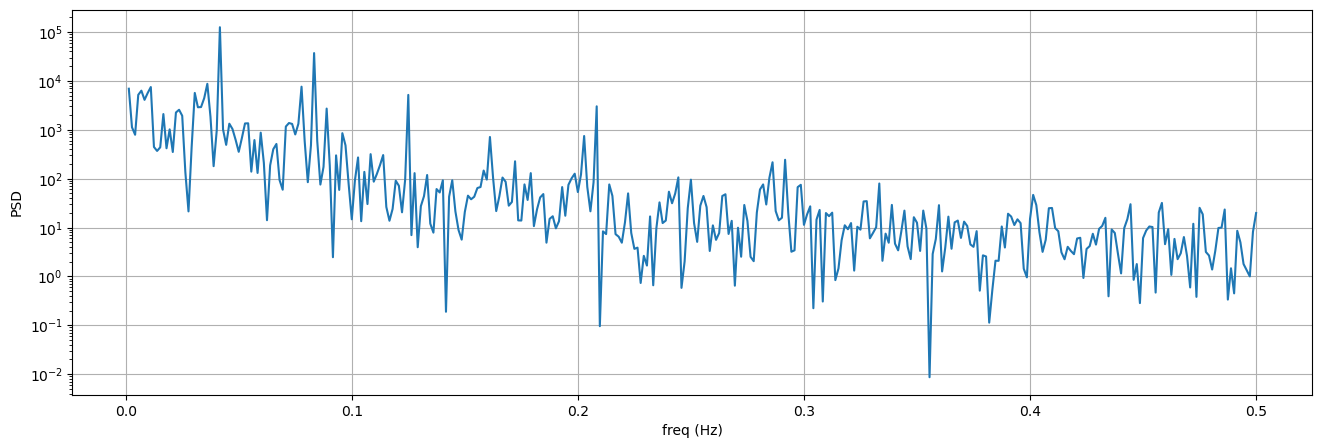

In [7]:
# generate periodogram
freq, Pxx_spec = signal.periodogram(df_april["Count"].values, scaling="spectrum")

# %% create graphic
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(freq[1:], Pxx_spec[1:])  # f[0]~0, dropped
plt.xlabel("freq (Hz)")
plt.ylabel("PSD")
plt.yscale("log")
plt.grid()


def getMaxPeriodogram(freq, Pxx_spec, num_top=5):
    # Find the indices of the top 'num_top' maximum PSDs
    top_indices = np.argsort(Pxx_spec)[-num_top:][::-1]

    # Extract the frequencies and PSDs for the top 'num_top' maximum PSDs
    freqMax = freq[top_indices]
    maxPsd = Pxx_spec[top_indices]
    # Convert to periods
    periodMax = 1 / freqMax
    return maxPsd, freqMax, periodMax


maxPsd, freqMax, periodMax = getMaxPeriodogram(freq, Pxx_spec)

list(1 / freqMax)

## Trying a tbats

In [8]:
# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="tbats_model_week") as run:
    # Fit the TBATS model
    tbats_model = TBATS(seasonal_periods=[24, 12], use_arma_errors=True, use_box_cox=True, use_damped_trend=False, use_trend=False, n_jobs = 8)
    tbats_fit = tbats_model.fit(df_april['Count'][:-48])

    # Forecast using the TBATS model
    forecast = tbats_fit.forecast(steps=48)

    # Calculate RMSE for the original model (not the forecast)
    rmse_train = np.sqrt(mean_squared_error(df_april['Count'][:-48], tbats_fit.y_hat))
    rmse_test = np.sqrt(mean_squared_error(df_april['Count'][-48:], forecast))

    # Calculate R-squared for the original model (not the forecast)
    r_squared = r2_score(df_april['Count'][:-48], tbats_fit.y_hat)

    # Calculate AIC (Akaike Information Criterion)
    aic = tbats_fit.aic

    mlflow.log_metrics({
        "AIC": aic,
        "R-squared": r_squared,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })


    # # Log the trained TBATS model
    # mlflow.sklearn.log_model(tbats_fit, "tbats_model")



In [9]:
forecast = tbats_fit.forecast(steps=168)

In [10]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + "may_data_processed.csv"

In [11]:
df_may_forecast = pd.read_csv(modified_path, index_col=[0])
df_may_forecast.Date = pd.to_datetime(df_may_forecast['Date'])
df_may_forecast.index = pd.to_datetime(df_may_forecast.index)

In [12]:
df_may_forecast = df_may_forecast[0:168]
df_may_forecast['forecast'] = forecast

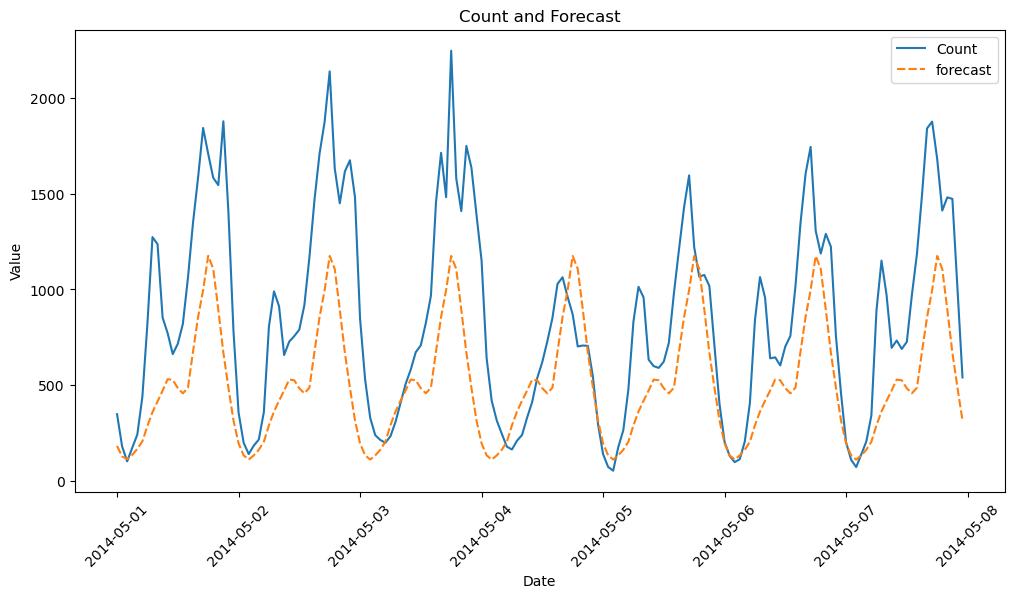

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_may_forecast[['Count', 'forecast']])


# Rotate the x-axis date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Count and Forecast')

# Show the plot
plt.legend()
plt.show()


Harmonic Regresion

In [14]:
# Start an MLflow run in the named experiment
with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="april_harmonic") as run:

    # periods
    # (1 day = 24 hours, 1 week = 168 hours)
    period01 = 24
    period02 = 12
    period03 = 8

# extract the number hourly samples
    T = len(df_april)
    time = np.arange(1, T + 1)

# create regressors for the daily period
    omega01 = 2 * np.pi / period01
    s1 = np.cos(omega01 * time)
    c1 = np.sin(omega01 * time)

# create regressors for the weekly period
    omega02 = 2 * np.pi / period02
    s2 = np.cos(omega02 * time)
    c2 = np.sin(omega02 * time)

    omega03 = 2 * np.pi / period03
    s3 = np.cos(omega03 * time)
    c3 = np.sin(omega03 * time)

# stack regressors and add intercept
    regressors = np.column_stack((s1, c1, s2, c2, s3, c3))
    regressors_one = sm.add_constant(regressors)

    # Define exog_var
    exog_var = regressors

    # Create and fit the regression model
    model = sm.OLS(df_april["Count"][:-48], regressors_one[:-48])
    results_harmonic = model.fit()

    y_pred_train = results_harmonic.predict(regressors_one[:-48])  
    y_pred_test = results_harmonic.predict(regressors_one[-48:]) 

    # Calculate AIC and R-squared
    aic = results_harmonic.aic
    r_squared = results_harmonic.rsquared
    rmse_train = np.sqrt(mean_squared_error(df_april["Count"][:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(df_april["Count"][-48:], y_pred_test))

# Log RMSE as a metric


    # Log model parameters
    mlflow.log_params({
        "period01": period01,
        "period02": period02,
        "period03": period03,
    })

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "R-squared": r_squared,
        "RMSE_Train": rmse_train,
        "RMSE_Test" : rmse_test
    })

    # Log the trained model
    # mlflow.sklearn.log_model(results_harmonic, "harmonic_model_all_data")

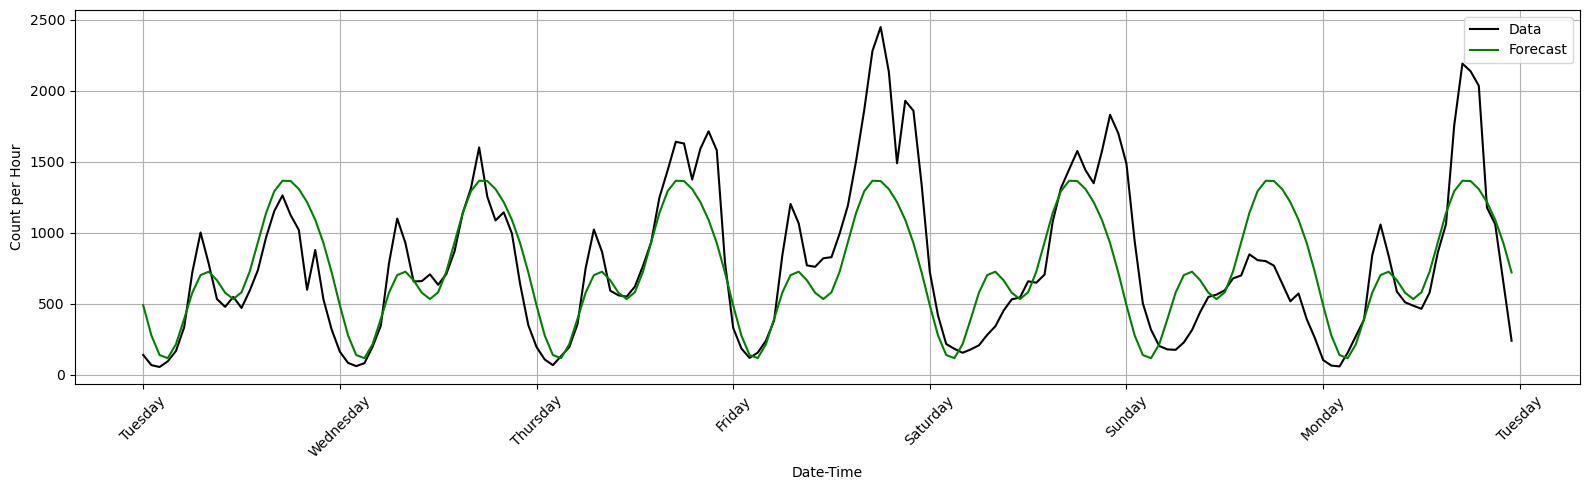

In [15]:
# plot the data and fitted values

plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_april.index[:168], df_april["Count"][:168], color="k", label="Data")

# Fitted values
plt.plot(df_april.index[:168], results_harmonic.fittedvalues[:168], color="green", label="Forecast")

# Add labels, ticks, and legend
plt.gca().set(xlabel="Date-Time", ylabel="Count per Hour")

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%A"))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

Key problem, the regression underestimates the weekly morning spikes due to the fact, that they do not exist on weekends, yet the overestimates the non existent weekend morning spikes

So, the idea is that we have two models here:

week and weekend

In [16]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + "df_april_week.csv"

In [17]:
# for training
df_april_week = pd.read_csv(modified_path,  index_col=[0])
df_april_week.Date = pd.to_datetime(df_april_week['Date'])
df_april_week.index = pd.to_datetime(df_april_week.index)

In [18]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + "df_may_week.csv"

In [19]:
# for forecasting
df_may_week = pd.read_csv(modified_path, index_col=[0]) 
df_may_week.Date = pd.to_datetime(df_may_week['Date'])
df_may_week.index = pd.to_datetime(df_may_week.index)

In [20]:
# generate periodogram
freq, Pxx_spec = signal.periodogram(
    df_april_week["Count"].values, scaling="spectrum"
)

In [21]:
maxPsd, freqMax_week, periodMax = getMaxPeriodogram(freq, Pxx_spec)

In [22]:
1 / freqMax_week

array([ 24.        ,  12.        , 105.6       ,   8.        ,
        31.05882353])

Version 1: With all the top 5 periodicites


In [23]:
# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="april_harmonic_week") as run:
    # Define periods
    period01 = 24
    period02 = 12
    period03 = 105.6
    period04 = 8
    period05 = 31.06

    # Extract the number hourly samples
    T = len(df_april_week)
    time = np.arange(1, T + 1)

    # Create regressors for the daily period
    omega01 = 2 * np.pi / period01
    s1 = np.cos(omega01 * time)
    c1 = np.sin(omega01 * time)

    # Create regressors for the weekly period
    omega02 = 2 * np.pi / period02
    s2 = np.cos(omega02 * time)
    c2 = np.sin(omega02 * time)

    omega03 = 2 * np.pi / period03
    s3 = np.cos(omega03 * time)
    c3 = np.sin(omega03 * time)

    omega04 = 2 * np.pi / period04
    s4 = np.cos(omega04 * time)
    c4 = np.sin(omega04 * time)

    omega05 = 2 * np.pi / period05
    s5 = np.cos(omega05 * time)
    c5 = np.sin(omega05 * time)

    # Stack regressors and add intercept
    regressors = np.column_stack((s1, c1, s2, c2, s3, c3, s4, c4, s5, c5))
    regressors_one = sm.add_constant(regressors)

    exog_var_week = regressors

    # Create and fit the regression model
    model = sm.OLS(df_april_week["Count"][:-48], regressors_one[:-48])
    results_harmonic_week = model.fit()

    # Make predictions
    y_pred_train = results_harmonic_week.predict(regressors_one[:-48])
    y_pred_test = results_harmonic_week.predict(regressors_one[-48:])

    # Calculate AIC and R-squared
    aic = results_harmonic_week.aic
    r_squared = results_harmonic_week.rsquared
    rmse_train = np.sqrt(mean_squared_error(df_april_week["Count"][:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(df_april_week["Count"][-48:], y_pred_test))


    # Log model parameters
    mlflow.log_params({
        "period01": period01,
        "period02": period02,
        "period03": period03,
        "period04": period04,
        "period05": period05
    })

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "R-squared": r_squared,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    # Log the trained model
    # mlflow.sklearn.log_model(results_harmonic_week, "harmonic_model")

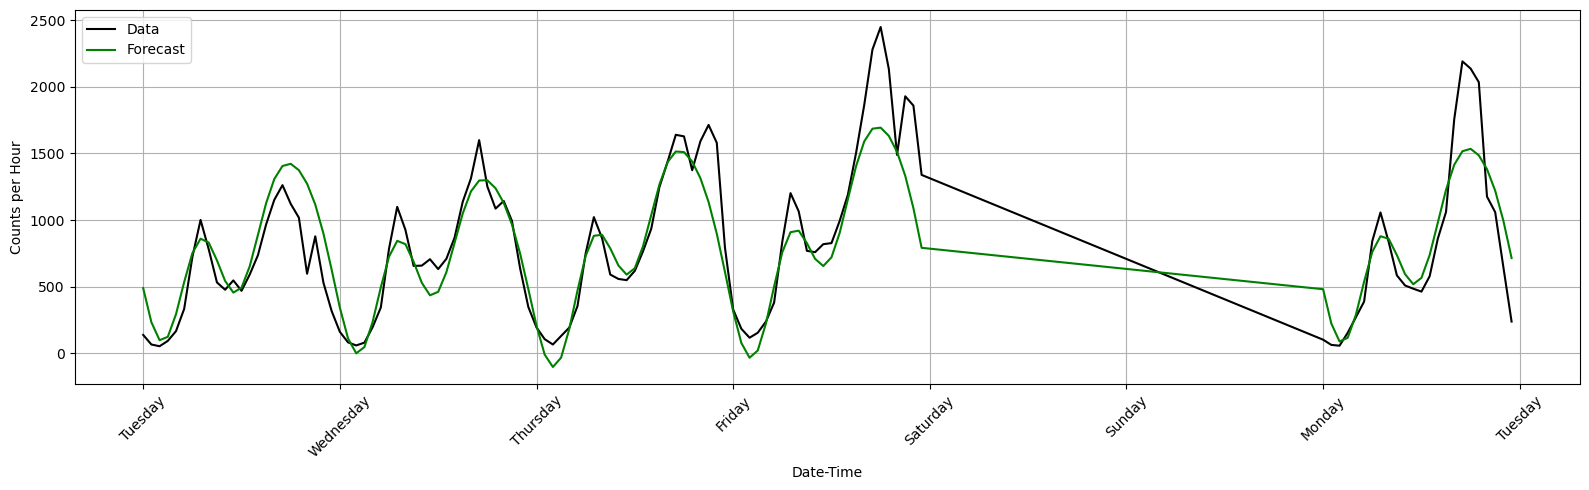

In [24]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_april_week.index[:120], df_april_week["Count"][:120], color="k", label="Data")

# Fitted values
plt.plot(
    df_april_week.index[:120],
    results_harmonic_week.fittedvalues[:120],
    color="green",
    label="Forecast",
)

# Add labels, ticks, and legend
plt.gca().set(xlabel="Date-Time", ylabel="Counts per Hour")

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%A"))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Trying a tbats for the week data

In [25]:
# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="tbats_model_week") as run:
    # Fit the TBATS model
    tbats_model = TBATS(seasonal_periods=[24], use_arma_errors=True, use_box_cox=True, use_damped_trend=True, use_trend=True, n_jobs=8)
    tbats_fit = tbats_model.fit(df_april_week['Count'][:-48])

    # Forecast using the TBATS model
    forecast = tbats_fit.forecast(steps=48)

    # Calculate RMSE for the original model (not the forecast)
    rmse_train = np.sqrt(mean_squared_error(df_april_week['Count'][:-48], tbats_fit.y_hat))
    rmse_test = np.sqrt(mean_squared_error(df_april_week['Count'][-48:], forecast))

    # Calculate R-squared for the original model (not the forecast)
    r_squared = r2_score(df_april_week['Count'][:-48], tbats_fit.y_hat)

    # Calculate AIC (Akaike Information Criterion)
    aic = tbats_fit.aic

    mlflow.log_metrics({
        "AIC": aic,
        "R-squared": r_squared,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })


    # Log the trained TBATS model
    # mlflow.sklearn.log_model(tbats_fit, "tbats_model")


### Predicting the weekend

In [26]:
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + "df_april_end.csv"

In [27]:
df_april_end = pd.read_csv(modified_path,  index_col=[0])
df_april_end.Date = pd.to_datetime(df_april_end['Date'])
df_april_end.index = pd.to_datetime(df_april_end.index)

In [28]:
# %% generate periodogram
freq, Pxx_spec = signal.periodogram(df_april_end["Count"].values, scaling="spectrum")

In [29]:
maxPsd_end, freqMax_end, periodMax_end = getMaxPeriodogram(freq, Pxx_spec)

In [30]:
1 / freqMax_end

array([ 24.,  48.,  16., 192.,  64.])

In [31]:
# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="april_harmonic_weekend") as run:
    # Define periods
    period01 = 24
    period02 = 48
    period03 = 16
    period04 = 192
    period05 = 64

    # Extract the number hourly samples
    T = len(df_april_end)
    time = np.arange(1, T + 1)

    # Create regressors for the daily period
    omega01 = 2 * np.pi / period01
    s1 = np.cos(omega01 * time)
    c1 = np.sin(omega01 * time)

    # Create regressors for the weekly period
    omega02 = 2 * np.pi / period02
    s2 = np.cos(omega02 * time)
    c2 = np.sin(omega02 * time)

    omega03 = 2 * np.pi / period03
    s3 = np.cos(omega03 * time)
    c3 = np.sin(omega03 * time)

    omega04 = 2 * np.pi / period04
    s4 = np.cos(omega04 * time)
    c4 = np.sin(omega04 * time)

    omega05 = 2 * np.pi / period05
    s5 = np.cos(omega05 * time)
    c5 = np.sin(omega05 * time)

    # Stack regressors and add intercept
    regressors = np.column_stack((s1, c1, s2, c2, s3, c3, s4, c4, s5, c5))
    regressors_one = sm.add_constant(regressors)

    exog_var_end = regressors

    # Create and fit the regression model
    model = sm.OLS(df_april_end["Count"][:-48], regressors_one[:-48])
    results_harmonic_end = model.fit()

    # Make predictions
    y_pred_train = results_harmonic_end.predict(regressors_one[:-48])
    y_pred_test = results_harmonic_end.predict(regressors_one[-48:])

    # Calculate AIC and R-squared
    aic = results_harmonic_end.aic
    r_squared = results_harmonic_end.rsquared
    rmse_train = np.sqrt(mean_squared_error(df_april_end["Count"][:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(df_april_end["Count"][-48:], y_pred_test))


    # Log model parameters
    mlflow.log_params({
        "period01": period01,
        "period02": period02,
        "period03": period03,
        "period04": period04,
        "period05": period05
    })

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "R-squared": r_squared,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    # Log the trained model
    # mlflow.sklearn.log_model(results_harmonic_end, "harmonic_model_end")

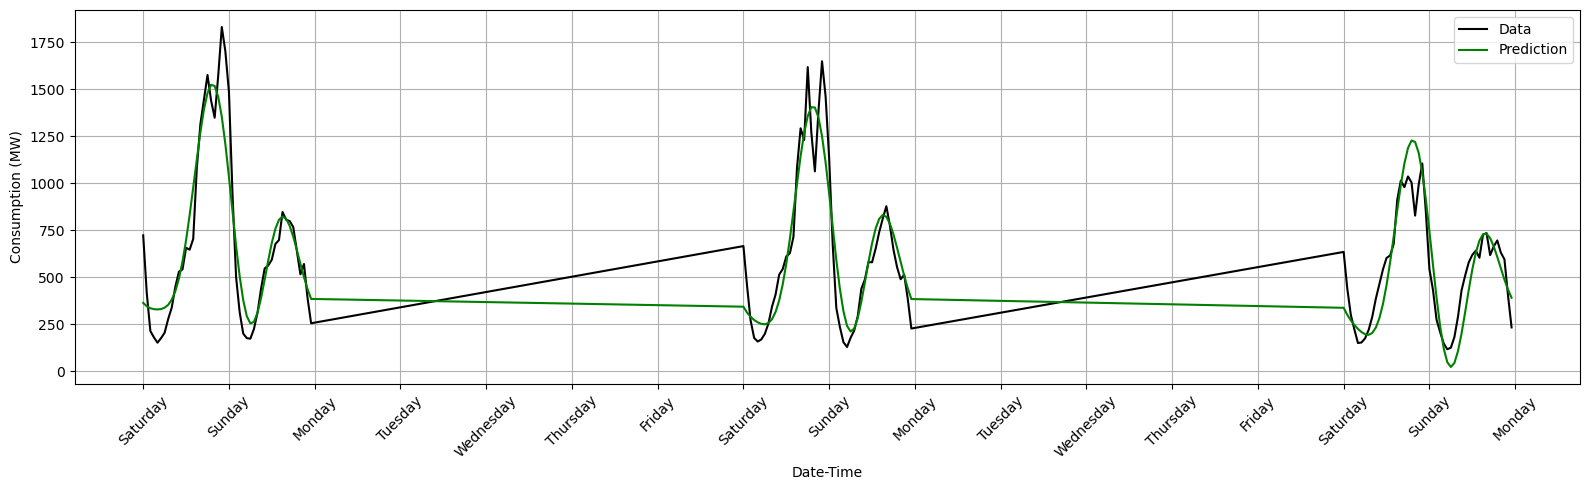

In [32]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_april_end.index[:-48], df_april_end["Count"][:-48], color="k", label="Data")

# Fitted values
plt.plot(
    df_april_end.index[:-48], results_harmonic_end.fittedvalues, color="green", label="Prediction"
)

# Add labels, ticks, and legend
plt.gca().set(xlabel="Date-Time", ylabel="Consumption (MW)")

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%A"))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Sarima Approach

Checking the results after the harmonic regression has been applied

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


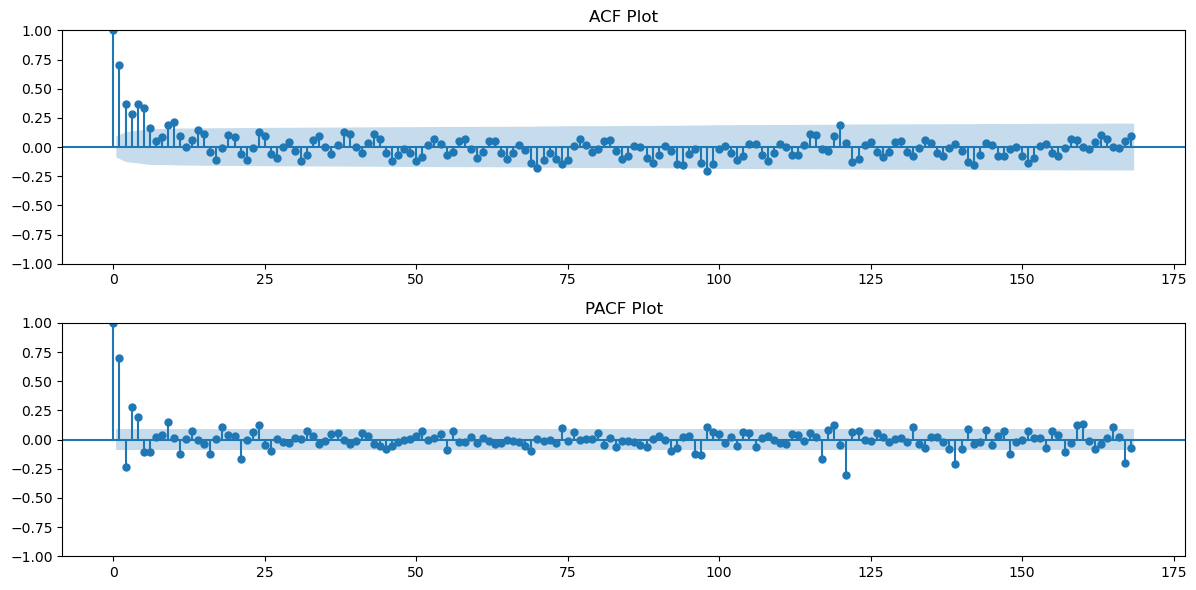

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_harmonic_week.resid, lags=168, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results_harmonic_week.resid, lags=168, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

This is an interesting pattern, hence its stationary no need for further differencing. Yet its not clear what model should be applied here.

Interpretation 1:
Both are exponentially decresasing, thus we need an ARMA model with p,q. We need to figure out what is the best model with AIC. 


Interpretation 2: ACF Expoenentially Decreasing.
PACF shuts of for lag either of the following lags: 9 11 16 18 21 23 24, this would imply AR model with one of the mentioned lags.

In [34]:
# Check if stationairy
result = adfuller(results_harmonic_week.resid)

# Extract and print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")


ADF Statistic: -4.069946324172618
p-value: 0.001085437992531693
Critical Values:
	1%: -3.444583778100581
	5%: -2.8678163032301995
	10%: -2.570113030490433


In [35]:
harmonic_residuals = results_harmonic_week.resid.reset_index()
harmonic_residuals = harmonic_residuals.drop(columns="index")

In [36]:
# after having run through both to 24 I figured out only to 4 makes sense in MA.
order_ar_list = list(range(0, 25, 1))
order_ma_list = list(range(0, 5, 1))

## Bruteforcing the Parameters

In [37]:
# aic_list = []
# ar_list = []
# ma_list = []
# warning_list = []

# # Set the filter to raise exceptions for all warnings
# warnings.simplefilter("error", category=UserWarning)

# for ar in order_ar_list:
#     for ma in order_ma_list:
#         try:
#             arma_model = sm.tsa.ARIMA(harmonic_residuals, order=(ar, 0, ma))
#             arma_result = arma_model.fit()
#             aic_list.append(arma_result.aic)
#             ar_list.append(ar)
#             ma_list.append(ma)
#             warning_list.append(0)  # No warning occurred, add 0 to the list
#             print(ar)
#             print(ma)
#             print(arma_result.aic)
#         except UserWarning as warn:
#             # Handle the UserWarning here
#             print("Caught a UserWarning as an exception:", warn)
#             aic_list.append(100000)
#             ar_list.append(ar)
#             ma_list.append(ma)
#             warning_list.append(1)  # UserWarning occurred, add 1 to the list


# df_aic = pd.DataFrame({'aic': aic_list, 'ar': ar_list, 'ma': ma_list, 'warning': warning_list})

In [38]:
# df_aic = df_aic.query("warning == 0")
# min_aic_row_index = df_aic['aic'].idxmin()
# # Get the row with the minimum 'aic' value
# df_aic.loc[min_aic_row_index]

In [39]:
# df_aic.nsmallest(10, 'aic')

This genereally speaks for interpretation 2 and that we should use ARMA 24 0

In [40]:
# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="arma_after_harmonic_regression_week") as run:
    arma_model = sm.tsa.ARIMA(harmonic_residuals[:-48], order=(24, 0, 0))
    arma_result = arma_model.fit()
   

    # Make predictions
    y_pred_train = arma_result.predict()
    forecast = arma_result.get_forecast(steps=48)
    y_pred_test = forecast.predicted_mean

    # Calculate AIC and R-squared
    aic = arma_result.aic
    
    rmse_train = np.sqrt(mean_squared_error(harmonic_residuals[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(harmonic_residuals[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    # Log the trained model
    # mlflow.sklearn.log_model(arma_result, "arma_after_harmonic")

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


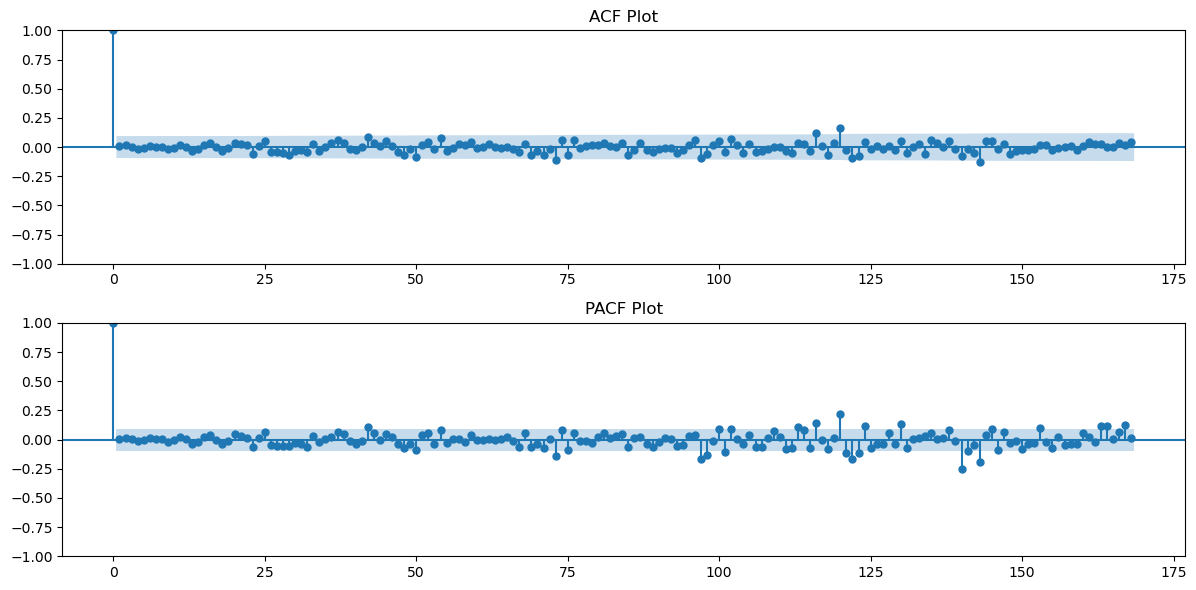

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(arma_result.resid, lags=168, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(arma_result.resid, lags=168, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

Goodbye Residuals. Have a nice one

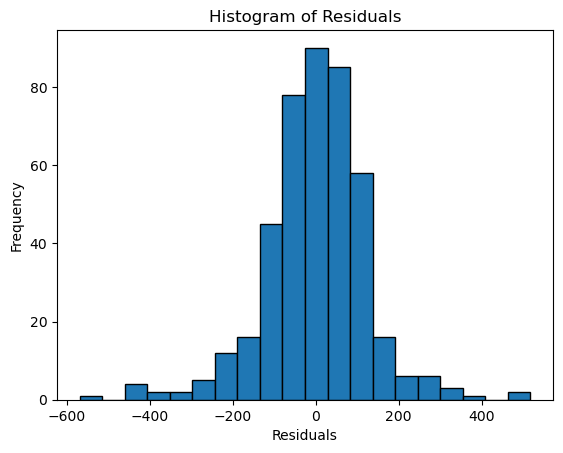

In [42]:
# Create a histogram for the residuals
plt.hist(
    arma_result.resid, bins=20, edgecolor="black"
)  # You can adjust the number of bins as needed
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

Ok so, Ljung-Box test looks good, all the serial correlation is accounted for.

# Next up: Combining it all together in Sarimax.

Interpretation 2: hence it has the lowest AIC. Also the other Options have higher AIC's in this contexts

In [43]:
endog = df_april_week["Count"].reset_index()
endog = endog.drop(columns='index')



# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="SARIMAX") as run:
    order = (24, 0, 0)
    seasonal_order = (0, 0, 0, 0)
    model_sarimax = SARIMAX(
        endog= endog[:-48],
        exog=exog_var_week[:-48],
        trend="c",
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True,
    )
    m_sarimax_24 = model_sarimax.fit()

    # Make predictions
    y_pred_train = m_sarimax_24.predict()
    forecast = m_sarimax_24.get_forecast(steps=48, exog=exog_var_week[-48:])
    y_pred_test = forecast.predicted_mean

    # Calculate AIC and R-squared
    aic = m_sarimax_24.aic
    
    rmse_train = np.sqrt(mean_squared_error(endog['Count'][:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog['Count'][-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    # Log the trained model
    # mlflow.sklearn.log_model(m_sarimax_24, "SARIMAX_24")

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


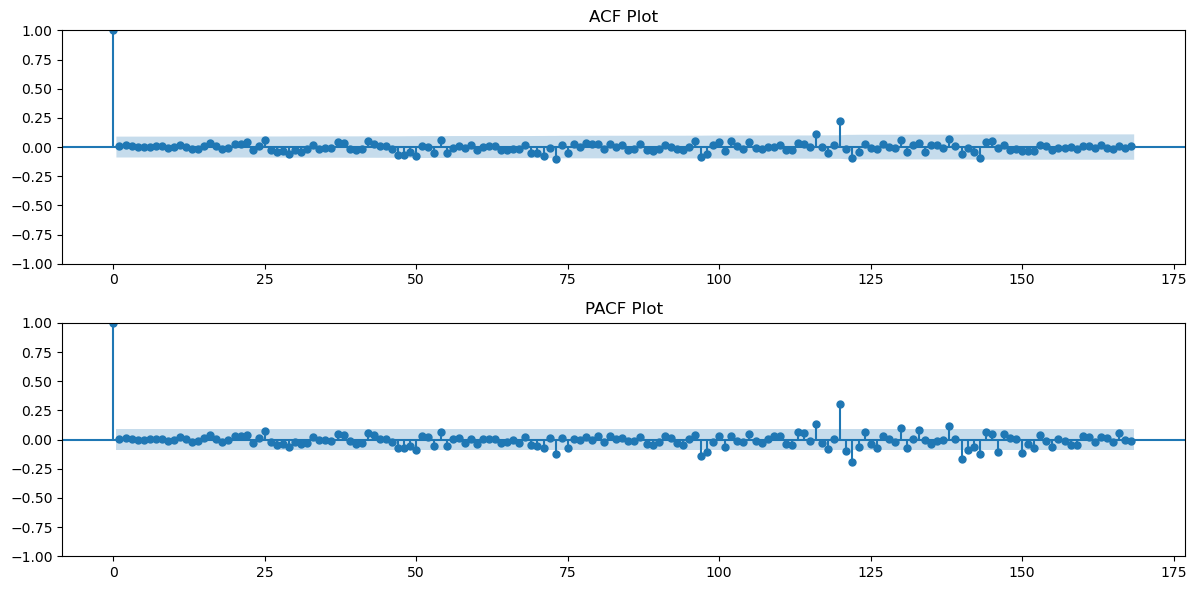

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(m_sarimax_24.resid, lags=168, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(m_sarimax_24.resid, lags=168, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

# Next up: pure SARIMA, no X

## Testing for Stationarity Differenced twice

In [45]:
result = adfuller(df_april_week["diff_Count24+1"][25:])

# Extract and print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -10.215092402979527
p-value: 5.508269528517531e-18
Critical Values:
	1%: -3.4436568932270095
	5%: -2.8674084917497074
	10%: -2.5698956806372832


## Testing for Stationarity Differenced once

In [46]:
result = adfuller(df_april_week["diff_Count24"][25:])

# Extract and print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -4.992288019274887
p-value: 2.2986468555822386e-05
Critical Values:
	1%: -3.4436298692815304
	5%: -2.867396599893435
	10%: -2.5698893429241916


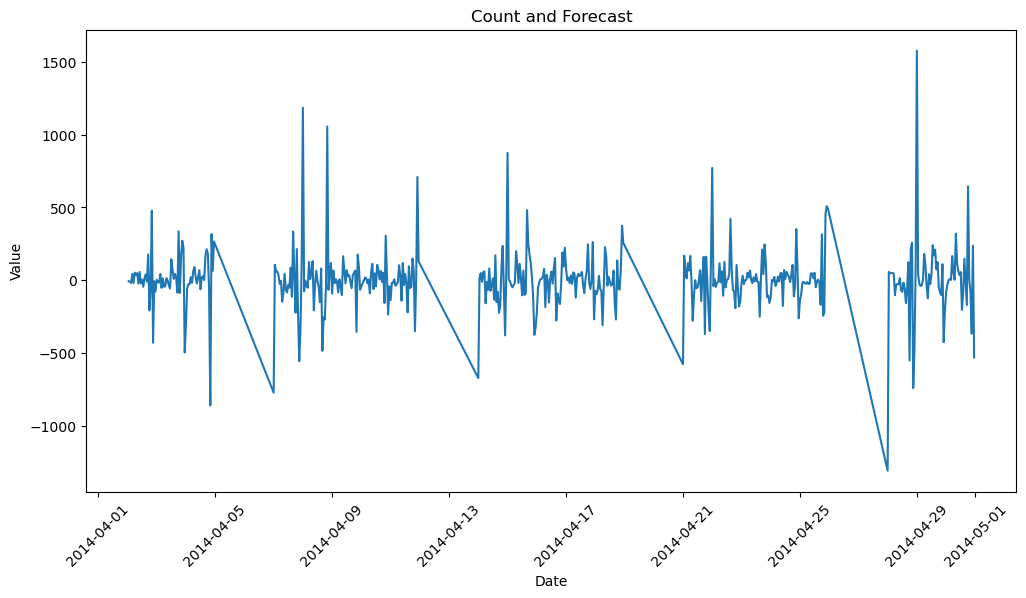

In [47]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_april_week["diff_Count24+1"])

# Rotate the x-axis date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Count and Forecast")

plt.show()

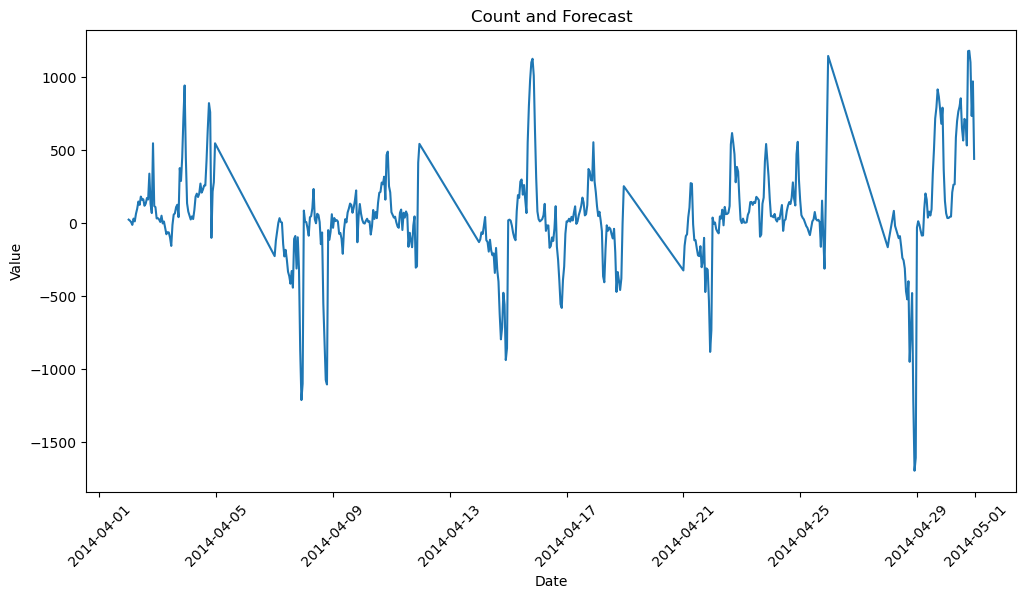

In [48]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_april_week["diff_Count24"])

# Rotate the x-axis date labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Count and Forecast")

plt.show()

In [49]:
print(np.var(df_april_week['diff_Count24']) > np.var(df_april_week['diff_Count24+1']))
print(np.var(df_april_week['diff_Count1']) > np.var(df_april_week['diff_Count24+1']))
print(np.var(df_april_week['Count']) > np.var(df_april_week['diff_Count24+1']))

# thus no overdifferencing
# https://people.duke.edu/~rnau/411arim2.htm#:~:text=Rule%202%3A%20If%20the%20lag,the%20series%20may%20be%20overdifferenced.
# Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.
# We could probably also go with 24 only, yet hence there is a long term trend lets keep it.


True
True
True


## checking the acf pacf plots for both

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


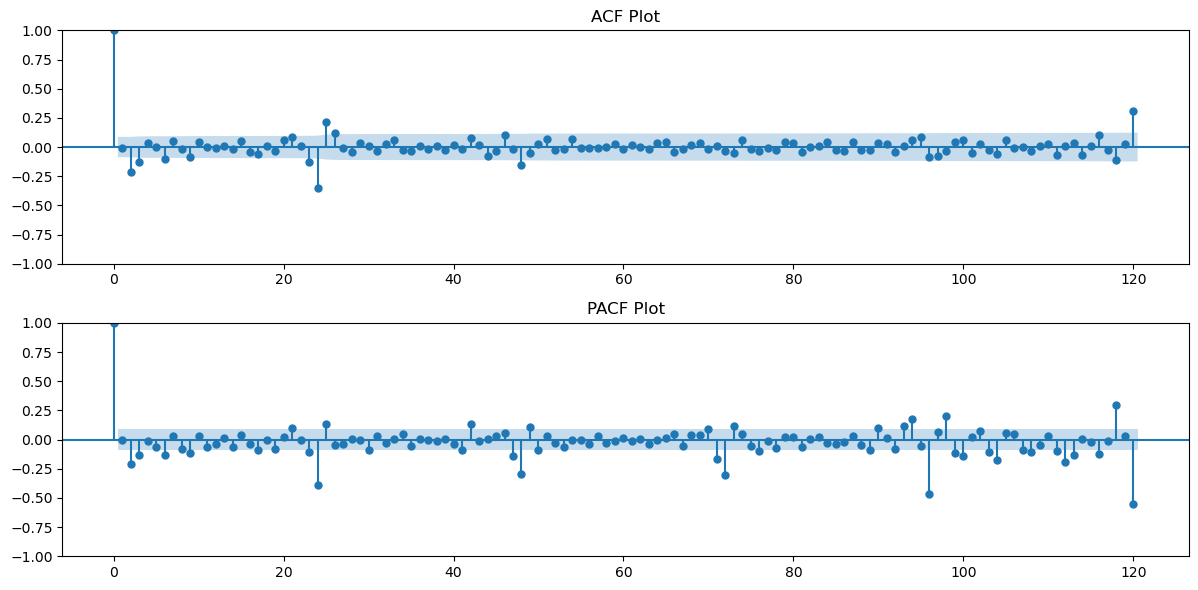

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_april_week["diff_Count24+1"][25:], lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(df_april_week["diff_Count24+1"][25:], lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

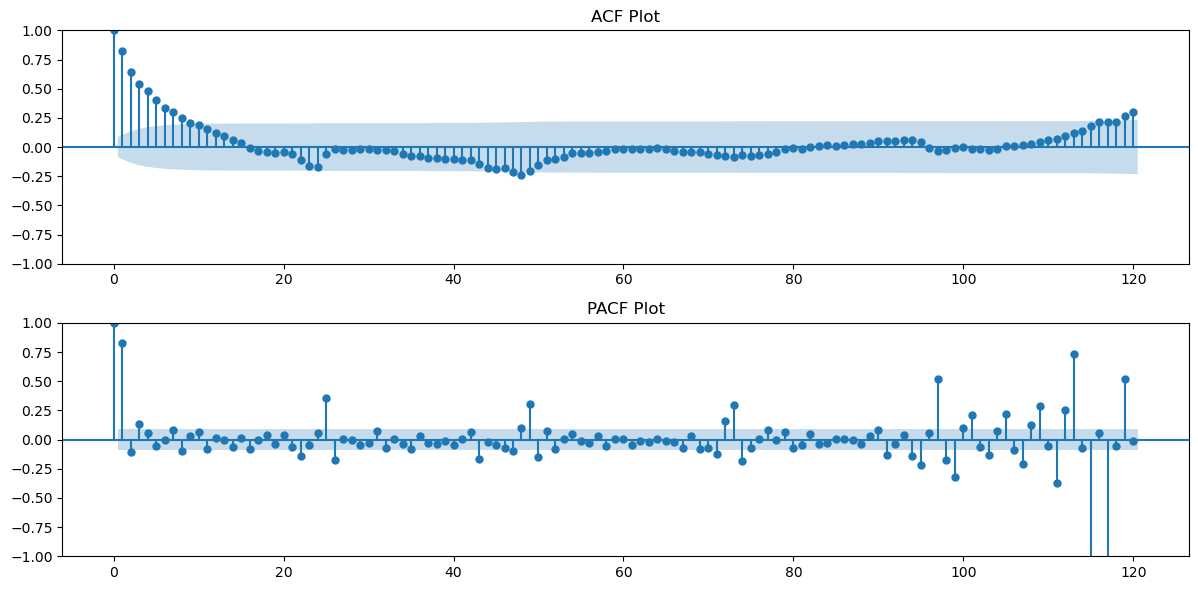

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_april_week["diff_Count24"][24:], lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(df_april_week["diff_Count24"][24:], lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

Interpretation 1:
The seasonsal difference plot could be seen as exponentially decaying ACF, which means whe would have an AR(1) and and Seasonal AR(24)

Interpretation 2: Both are slowly decaying in the twice differenced plot, thus we have to brute force our way trogh the right parameters


### Interpretation 1

In [52]:
endog = df_april_week["Count"].reset_index()
endog = endog.drop(columns='index')
order = (1, 0, 0)
seasonal_order = (1, 1, 0, 24)

# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"SARIMAX{order}, {seasonal_order}") as run:
    # Define the SARIMA order and seasonal order
    

    # Fit the SARIMA model with exogenous variables
    model = SARIMAX(endog[:-48], order=order, seasonal_order=seasonal_order)
    results = model.fit()
    
    # Calculate AIC, RMSE for training, and RMSE for testing
    aic = results.aic
    y_pred_train = results.fittedvalues
    y_pred_test = results.forecast(steps=48)
    rmse_train = np.sqrt(mean_squared_error(endog[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    mlflow.log_params({
    "order": order,
    "seasonal_order": seasonal_order
     })
    # Log the trained model
    # mlflow.sklearn.log_model(results, "SARIMA")



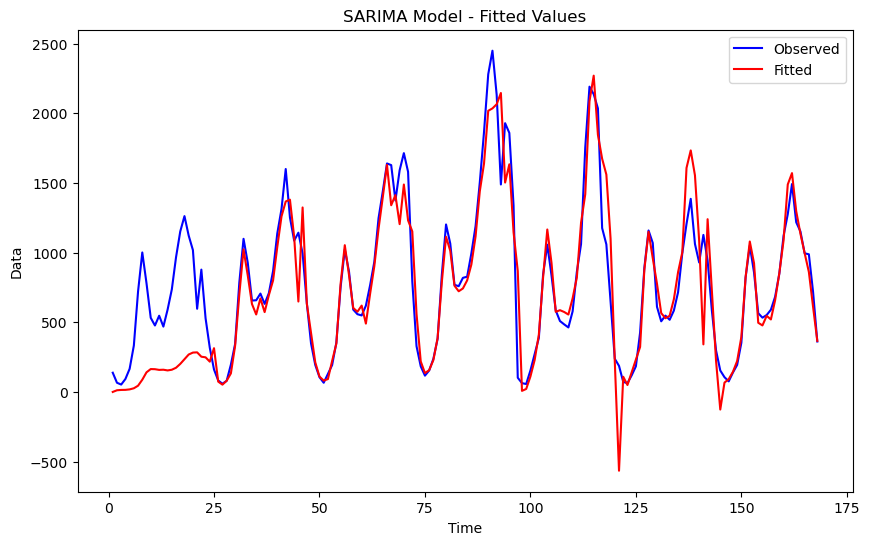

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


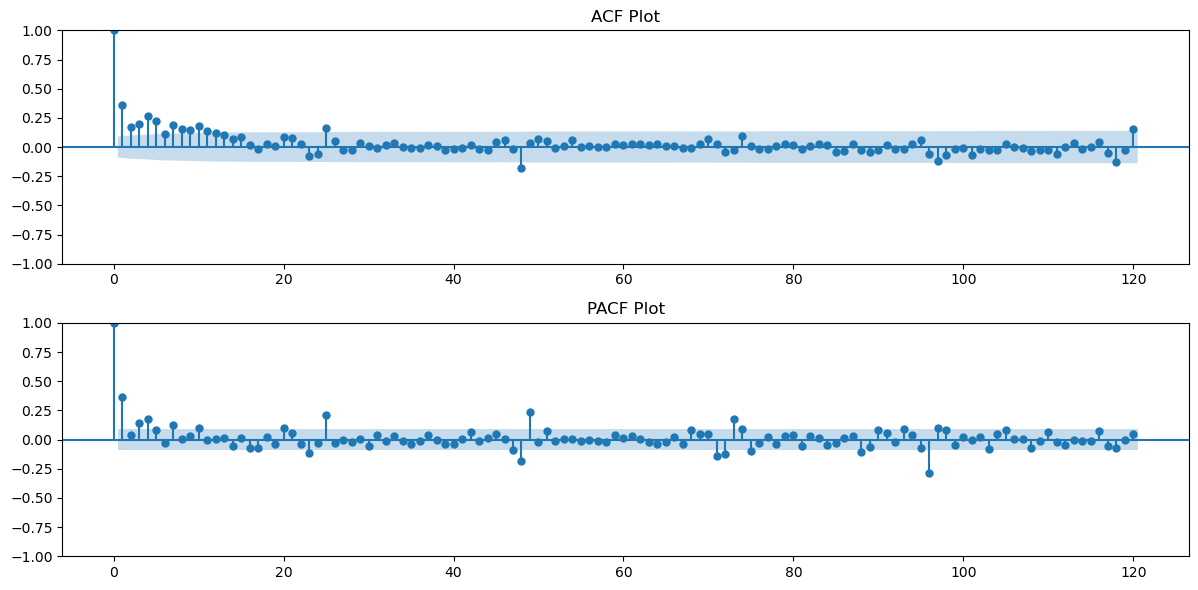

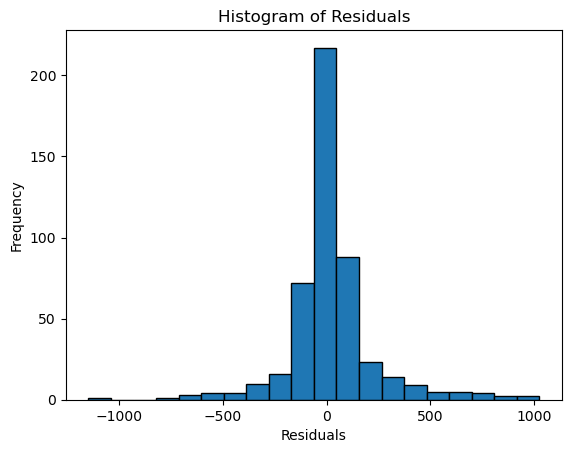

In [53]:
# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[0:168], df_april_week["Count"][0:168], label="Observed", color="blue")
plt.plot(time[0:168], results.fittedvalues[0:168], label="Fitted", color="red")
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("SARIMA Model - Fitted Values")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results.resid, lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results.resid, lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()


# Create a histogram for the residuals
plt.hist(
    results.resid, bins=20, edgecolor="black"
)  # You can adjust the number of bins as needed
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()    

### Interpretation 2

In [78]:
endog = df_april_week["Count"].reset_index()
endog = endog.drop(columns='index')
order = (1, 0, 0)
seasonal_order = (7, 1, 0, 24)

# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"SARIMAX{order}, {seasonal_order}") as run:
    # Define the SARIMA order and seasonal order
    

    # Fit the SARIMA model with exogenous variables
    model = SARIMAX(endog[:-48], order=order, seasonal_order=seasonal_order)
    results_1_7 = model.fit()
    
    # Calculate AIC, RMSE for training, and RMSE for testing
    aic =  results_1_7.aic
    y_pred_train =  results_1_7.fittedvalues
    y_pred_test =  results_1_7.forecast(steps=48)
    rmse_train = np.sqrt(mean_squared_error(endog[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    mlflow.log_params({
    "order": order,
    "seasonal_order": seasonal_order
     })
    # Log the trained model
    # mlflow.sklearn.log_model(results, "SARIMA")



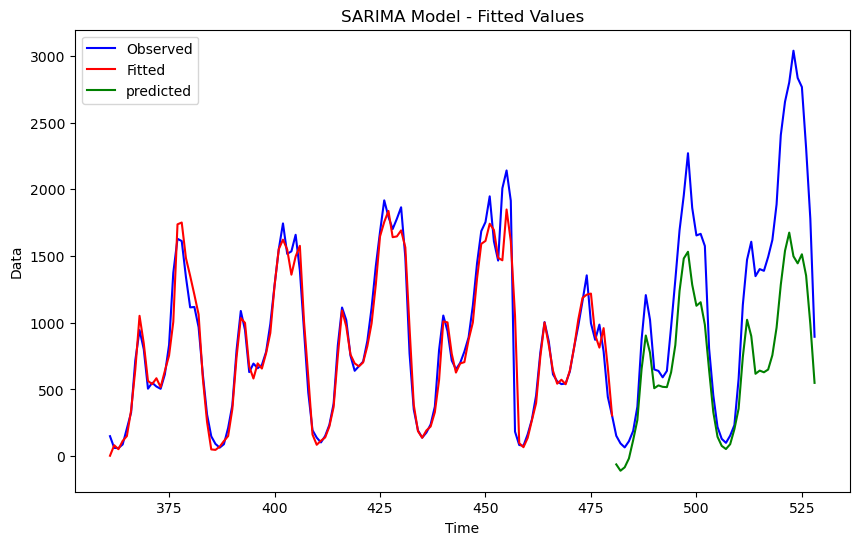

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


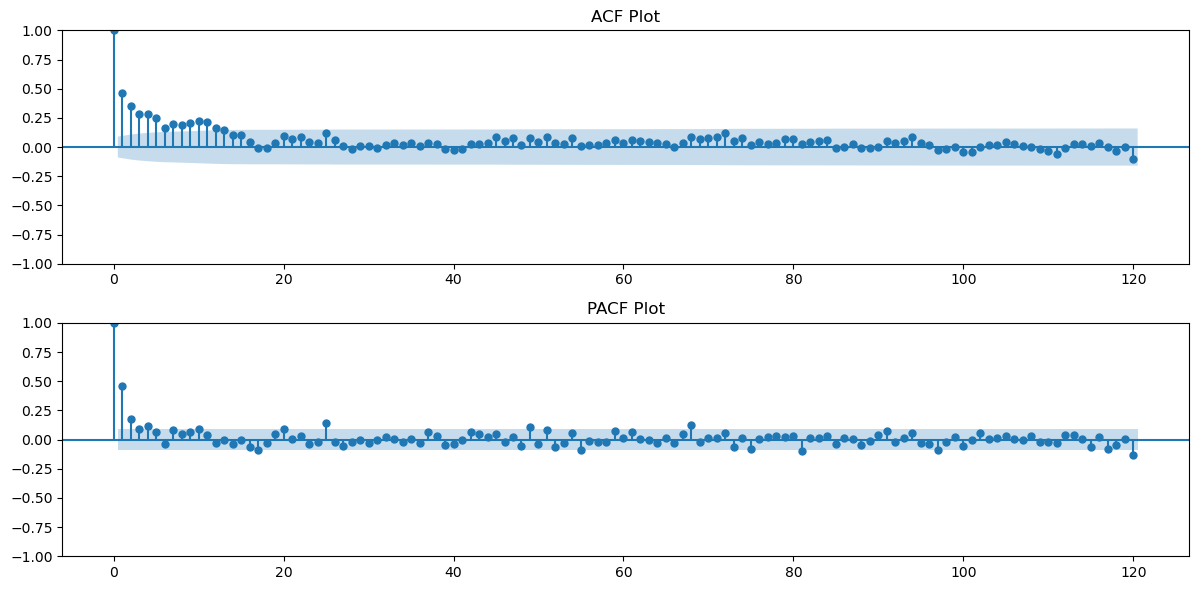

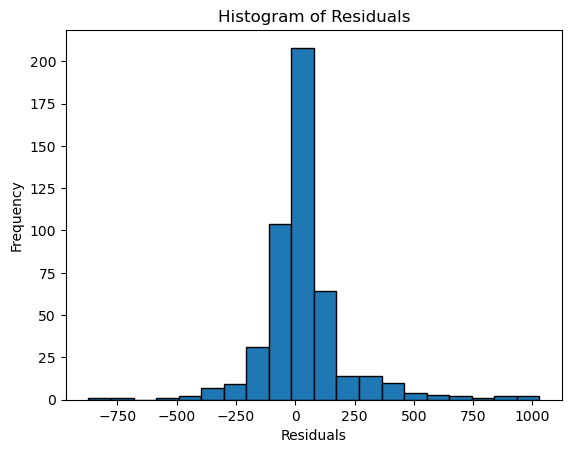

In [79]:
# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[360:], df_april_week["Count"][360:], label="Observed", color="blue")
plt.plot(time[360:480], results_1_7.fittedvalues[360:480], label="Fitted", color="red")
plt.plot(time[480:], y_pred_test, label="predicted", color="green")
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("SARIMA Model - Fitted Values")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_1_7.resid, lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results_1_7.resid, lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()


# Create a histogram for the residuals
plt.hist(
    results_1_7.resid, bins=20, edgecolor="black"
)  # You can adjust the number of bins as needed
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()    

lets brute force our way to the optimal parameters

In [56]:
# # after having run through both to 24 I figured out only to 4 makes sense in MA.
# order_ar_list = list(range(0,7,1))
# order_ma_list = list(range(0,7,1))
# seasonal_order_ar_list = list(range(0,2,1))
# seasonal_order_ma_list = list(range(0,2,1))
# normal_integration_list = list(range(0,2,1))

# ar_list = []
# ma_list = []
# warning_list = []
# aic_list = []
# ar_list_seasonal = []
# ma_list_seasonal = []
# integreation_list_seasonal = []


# # Set the filter to raise exceptions for all warnings
# warnings.simplefilter("error", category=UserWarning)

# for ar in order_ar_list:
#     for ma in order_ma_list:
#         for seasonal_ar in seasonal_order_ar_list:
#             for integration in normal_integration_list:
#                 for seasonal_ma in seasonal_order_ma_list:
#                     try:
#                         arma_model = SARIMAX(endog, order=(ar, integration, ma), seasonal_order=(seasonal_ar, 1, seasonal_ma, 24))
#                         arma_result = arma_model.fit()
#                         aic_list.append(arma_result.aic)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(integration)
#                         warning_list.append(0)  # No warning occurred, add 0 to the list
#                         print(ar)
#                         print(ma)
#                         print(arma_result.aic)
#                     except UserWarning as warn:
#                     # Handle the UserWarning here
#                         print("Caught a UserWarning as an exception:", warn)
#                         aic_list.append(1000000)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(integration)
#                         warning_list.append(1)  # UserWarning occurred, add 1 to the list
#                     except np.linalg.LinAlgError as linalg_err:
#                         # Handle the LinAlgError here
#                         print("Caught a LinAlgError as an exception:", linalg_err)
#                         aic_list.append(1000000)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(integration)
#                         warning_list.append(1)  # LinAlgError occurred, add 1 to the list


# df_aic_week_integration_regular = pd.DataFrame({'aic': aic_list, 'ar': ar_list, 'ma': ma_list, 'seasonal_ar' : ar_list_seasonal, 'integration' : integreation_list_seasonal, 'seasonal_ma' : ma_list_seasonal, 'warning': warning_list})

# file_name = "df_aic_april_week_integreation_regular.csv"
# notebook_path = os.path.abspath("3. Experiments in April.ipynb")
# notebook_directory = os.path.dirname(notebook_path)

# replacement_string = "data\\interim"
# index = notebook_directory.find("\\notebooks")
# modified_path = notebook_directory[:index]

# modified_path += "\\" + replacement_string + "\\" + file_name

# df_aic_week_integration_regular.to_csv(modified_path, index=True)




In [57]:
file_name = "df_aic_april_week.csv"
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + file_name

In [58]:
df_aic = pd.read_csv(modified_path)
sorted_df = df_aic.sort_values(by="aic", ascending=True)
top_10_rows = sorted_df.head(10)
top_10_rows

,aic,ar,ma,seasonal_ar,seasonal_integration,seasonal_ma,warning
55,6512.274520,0,6,1,1,1,0
491,6514.169607,5,1,0,1,1,0
187,6515.007061,1,11,0,1,1,0
183,6516.525435,1,10,1,1,1,0
119,6517.935714,1,2,1,1,1,0
883,6517.959685,9,2,0,1,1,0
595,6518.139040,6,2,0,1,1,0
203,6518.560506,2,1,0,1,1,0
215,6519.141796,2,2,1,1,1,0
887,6519.780470,9,2,1,1,1,0


In [59]:
file_name = "df_aic_april_week_integreation_regular.csv"
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + file_name

In [60]:
df_aic_integration_regular = pd.read_csv(modified_path, index_col=[0])
sorted_df = df_aic_integration_regular.sort_values(by="aic", ascending=True)
top_10_rows = sorted_df.head(10)
top_10_rows

,aic,ar,ma,seasonal_ar,integration,seasonal_ma,warning
55,6512.274520,0,6,1,1,1,0
291,6514.169607,5,1,0,1,1,0
79,6517.935714,1,2,1,1,1,0
355,6518.139040,6,2,0,1,1,0
123,6518.560506,2,1,0,1,1,0
135,6519.141796,2,2,1,1,1,0
139,6520.093345,2,3,0,1,1,0
127,6520.341216,2,1,1,1,1,0
143,6521.986840,2,3,1,1,1,0
27,6523.343088,0,3,0,1,1,0


### Interpretation 3, due to bruteforece

In [61]:
endog = df_april_week["Count"].reset_index()
endog = endog.drop(columns='index')

In [62]:
order = (0, 1, 6)
seasonal_order = (1, 1, 1, 24)



# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"SARIMAX{order}, {seasonal_order}") as run:
    # Define the SARIMA order and seasonal order
    

    # Fit the SARIMA model with exogenous variables
    model = SARIMAX(endog[:-48], order=order, seasonal_order=seasonal_order)
    results_week_sarima06 = model.fit()
    
    # Calculate AIC, RMSE for training, and RMSE for testing
    aic = results_week_sarima06.aic
    y_pred_train = results_week_sarima06.fittedvalues
    y_pred_test = results_week_sarima06.forecast(steps=48)
    rmse_train = np.sqrt(mean_squared_error(endog[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    mlflow.log_params({
    "order": order,
    "seasonal_order": seasonal_order
     })
    # Log the trained model
    # mlflow.sklearn.log_model(results_week_sarima06, "SARIMA_06")



c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


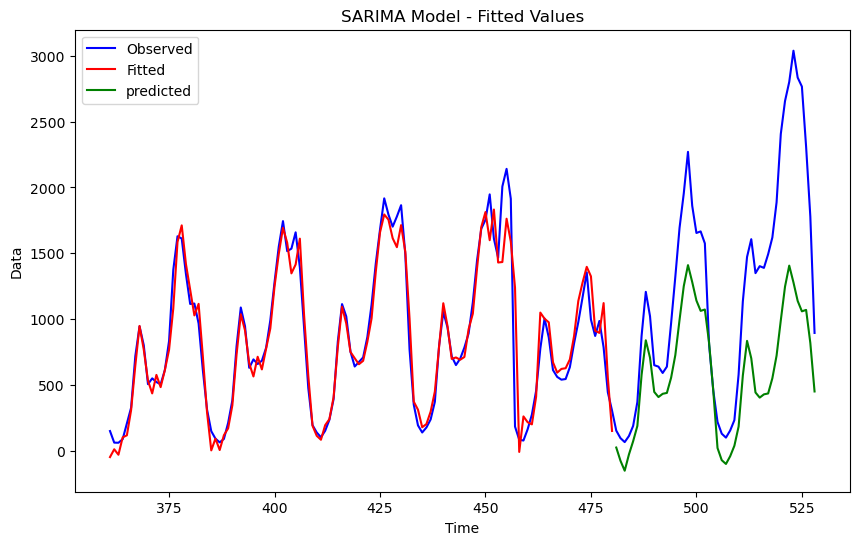

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


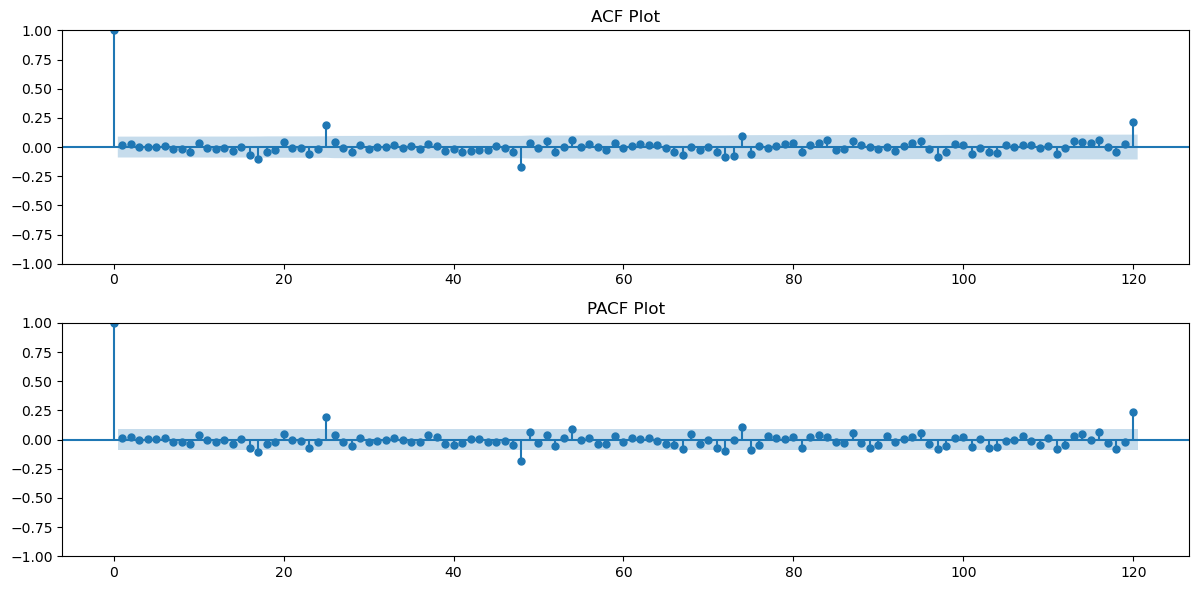

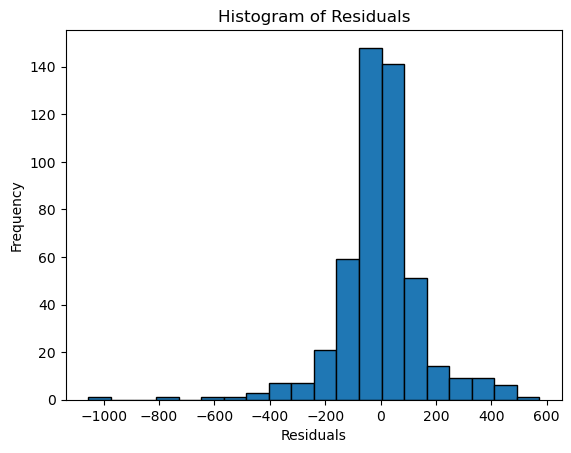

In [63]:
T = len(endog)
time = np.arange(1, T + 1)


# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[360:], df_april_week["Count"][360:], label="Observed", color="blue")
plt.plot(time[360:480], results_week_sarima06.fittedvalues[360:480], label="Fitted", color="red")
plt.plot(time[480:], y_pred_test, label="predicted", color="green")
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("SARIMA Model - Fitted Values")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_week_sarima06.resid, lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results_week_sarima06.resid, lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()


# Create a histogram for the residuals
plt.hist(
    results_week_sarima06.resid, bins=20, edgecolor="black"
)  # You can adjust the number of bins as needed
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()    

### Interpretation 4

In [64]:
order = (0, 1, 6)
seasonal_order = (7, 1, 1, 24)



# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"SARIMAX{order}, {seasonal_order}") as run:
    # Define the SARIMA order and seasonal order
    

    # Fit the SARIMA model with exogenous variables
    model = SARIMAX(endog[:-48], order=order, seasonal_order=seasonal_order)
    results_week_sarima1_7 = model.fit()
    
    # Calculate AIC, RMSE for training, and RMSE for testing
    aic = results_week_sarima06.aic
    y_pred_train = results_week_sarima1_7.fittedvalues
    y_pred_test = results_week_sarima1_7.forecast(steps=48)
    rmse_train = np.sqrt(mean_squared_error(endog[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    mlflow.log_params({
    "order": order,
    "seasonal_order": seasonal_order
     })
    # Log the trained model
    # mlflow.sklearn.log_model(results_week_sarima06, "SARIMA_06")



c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


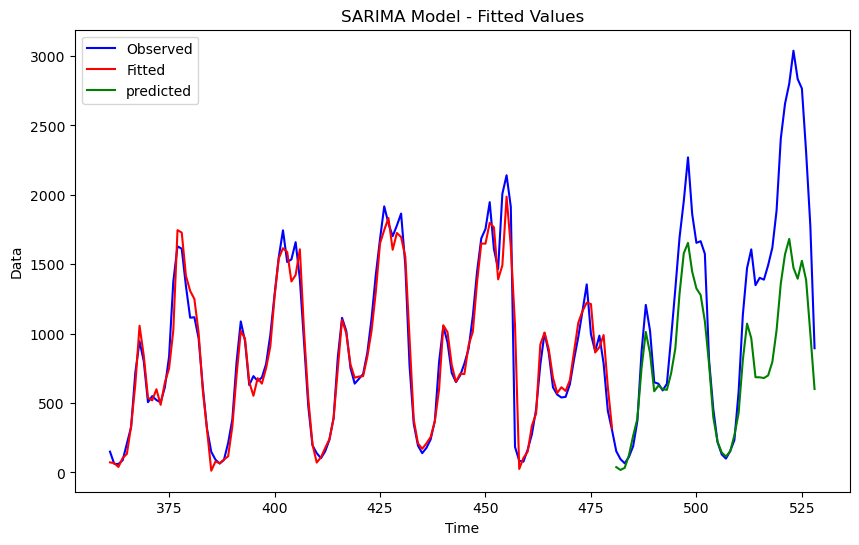

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


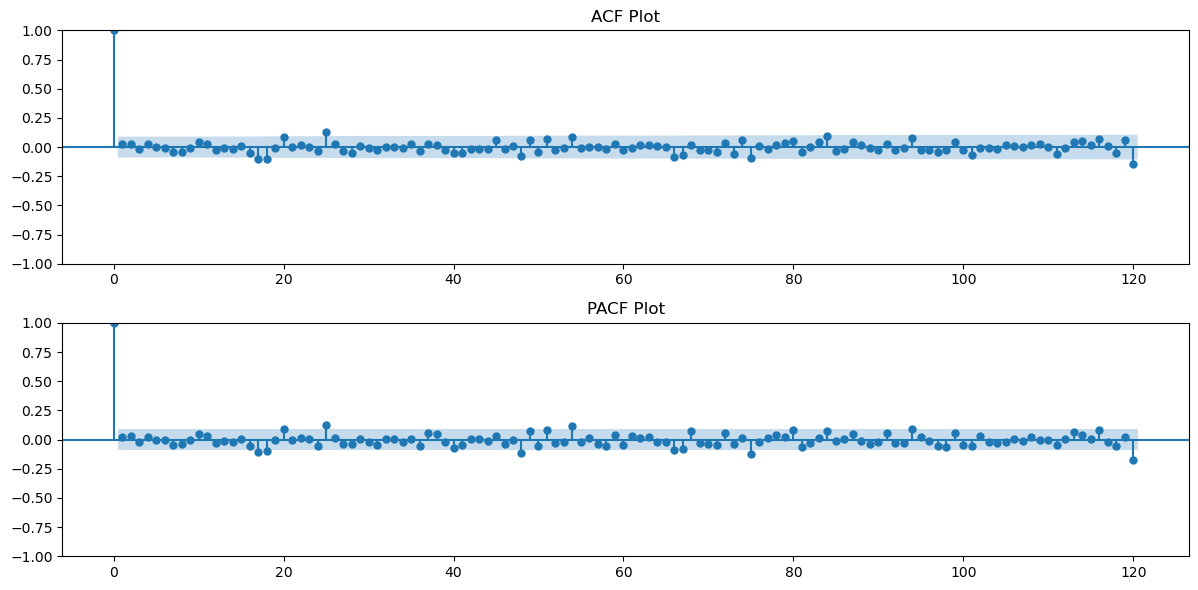

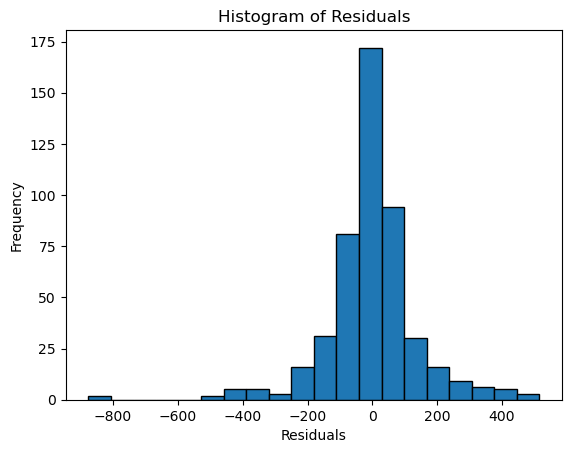

In [65]:
T = len(endog)
time = np.arange(1, T + 1)


# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[360:], df_april_week["Count"][360:], label="Observed", color="blue")
plt.plot(time[360:480], results_week_sarima1_7.fittedvalues[360:480], label="Fitted", color="red")
plt.plot(time[480:], y_pred_test, label="predicted", color="green")
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("SARIMA Model - Fitted Values")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_week_sarima1_7.resid, lags=120, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results_week_sarima1_7.resid, lags=120, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()


# Create a histogram for the residuals
plt.hist(
    results_week_sarima1_7.resid, bins=20, edgecolor="black"
)  # You can adjust the number of bins as needed
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()    

# Predicting the weekend

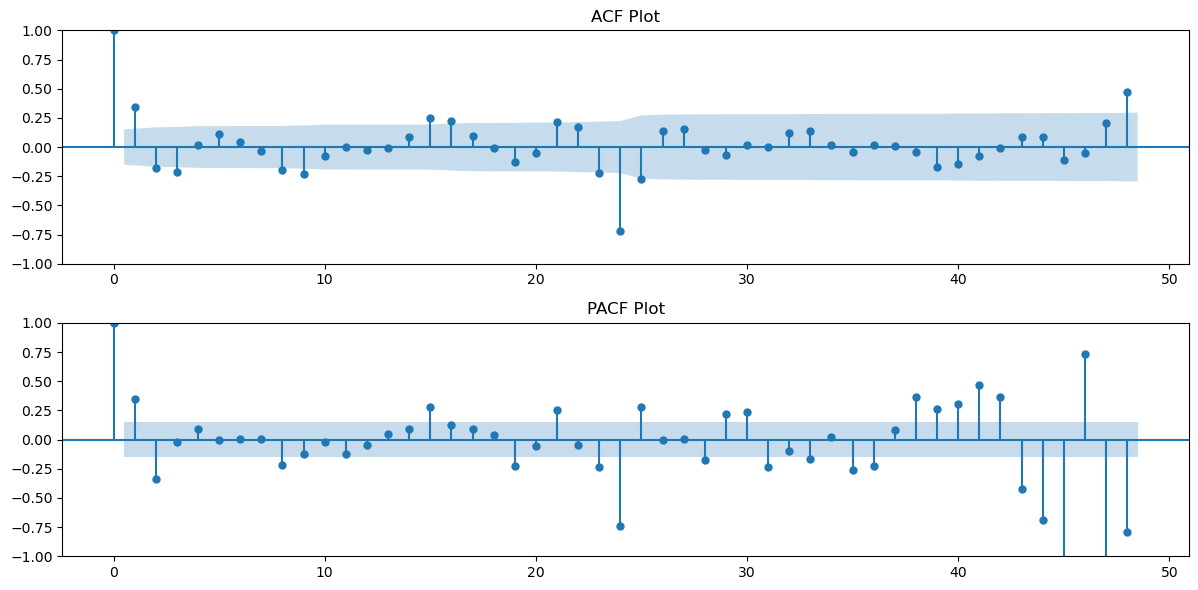

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_april_end["diff_Count24+1"][25:], lags=48, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(df_april_end["diff_Count24+1"][25:], lags=48, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

In [67]:
# df_reset = df_april_end.reset_index(drop=True)

# # the order lists for gridsearch
# order_ar_list = list(range(0,7,1))
# order_ma_list = list(range(0,7,1))
# seasonal_order_ar_list = list(range(0,3,1))
# seasonal_order_ma_list = list(range(0,3,1))
# seasonal_order_integration_list = list(range(0,2,1))

# ar_list = []
# ma_list = []
# warning_list = []
# aic_list = []
# ar_list_seasonal = []
# ma_list_seasonal = []
# integreation_list_seasonal = []


# # Set the filter to raise exceptions for all warnings
# warnings.simplefilter("error", category=UserWarning)

# for ar in order_ar_list:
#     for ma in order_ma_list:
#         for seasonal_ar in seasonal_order_ar_list:
#             for seasonal_integration in seasonal_order_integration_list:
#                 for seasonal_ma in seasonal_order_ma_list:
#                     try:
#                         arma_model = SARIMAX(endog=df_reset['Count'], order=(ar, 1, ma), seasonal_order=(seasonal_ar, seasonal_integration, seasonal_ma, 24))
#                         arma_result = arma_model.fit()
#                         aic_list.append(arma_result.aic)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(seasonal_integration)
#                         warning_list.append(0)  # No warning occurred, add 0 to the list
#                         print(ar)
#                         print(ma)
#                         print(arma_result.aic)
#                     except UserWarning as warn:
#                     # Handle the UserWarning here
#                         print("Caught a UserWarning as an exception:", warn)
#                         aic_list.append(1000000)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(seasonal_integration)
#                         warning_list.append(1)  # UserWarning occurred, add 1 to the list
#                     except np.linalg.LinAlgError as linalg_err:
#                         # Handle the LinAlgError here
#                         print("Caught a LinAlgError as an exception:", linalg_err)
#                         aic_list.append(1000000)
#                         ar_list.append(ar)
#                         ma_list.append(ma)
#                         ar_list_seasonal.append(seasonal_ar)
#                         ma_list_seasonal.append(seasonal_ma)
#                         integreation_list_seasonal.append(seasonal_integration)
#                         warning_list.append(1)  # LinAlgError occurred, add 1 to the list

# file_name = "df_aic_april_end.csv"
# notebook_path = os.path.abspath("3. Experiments in April.ipynb")
# notebook_directory = os.path.dirname(notebook_path)

# replacement_string = "data\\interim"
# index = notebook_directory.find("\\notebooks")
# modified_path = notebook_directory[:index]

# modified_path += "\\" + replacement_string + "\\" + file_name




# df_aic_end = pd.DataFrame({'aic': aic_list, 'ar': ar_list, 'ma': ma_list, 'seasonal_ar' : ar_list_seasonal, 'seasonal_integration' : integreation_list_seasonal, 'seasonal_ma' : ma_list_seasonal, 'warning': warning_list})

# df_aic_end.to_csv(modified_path, index=True)


In [68]:
file_name = "df_aic_april_end.csv"
notebook_path = os.path.abspath("3. Experiments in April.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "\\" + file_name


In [69]:
df_aic_end = pd.read_csv(modified_path, index_col=[0])
df_aic_end_0=df_aic_end.query("warning == 0")
sorted_df_end_0 = df_aic_end_0.sort_values(by="aic", ascending=True)
low_10_rows = sorted_df_end_0.head(10)
low_10_rows

,aic,ar,ma,seasonal_ar,seasonal_integration,seasonal_ma,warning
34,10.000000,0,1,2,1,1,0
802,22.000000,6,2,1,1,1,0
405,2072.114746,3,1,1,1,0,0
262,2073.292970,2,0,1,1,1,0
52,2073.664871,0,2,2,1,1,0
28,2073.782719,0,1,1,1,1,0
303,2073.822024,2,2,2,1,0,0
388,2073.917201,3,0,1,1,1,0
27,2073.939290,0,1,1,1,0,0
142,2074.123656,1,0,2,1,1,0


In [70]:
endog_end = df_april_end["Count"].reset_index()
endog_end = endog_end.drop(columns='index')


order=(3, 1, 1)
seasonal_order=(1, 1, 0, 24)


# Create an MLflow experiment and start a run
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"SARIMAX{order}, {seasonal_order}_end") as run:
    # Define the SARIMA order and seasonal order
    

    # Fit the SARIMA model with exogenous variables
    model = SARIMAX(endog_end[:-48], order=order, seasonal_order=seasonal_order)
    results_end_sarima = model.fit()
    
    # Calculate AIC, RMSE for training, and RMSE for testing
    aic = results_end_sarima.aic
    y_pred_train = results_end_sarima.fittedvalues
    y_pred_test = results_end_sarima.forecast(steps=48)
    rmse_train = np.sqrt(mean_squared_error(endog_end[:-48], y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(endog_end[-48:], y_pred_test))

    # Log AIC and R-squared
    mlflow.log_metrics({
        "AIC": aic,
        "RMSE_Train" : rmse_train,
        "RMSE_Test" : rmse_test
    })

    mlflow.log_params({
    "order": order,
    "seasonal_order": seasonal_order
     })
    # Log the trained model
    # mlflow.sklearn.log_model(results_end_sarima, "SARIMA_end")



c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


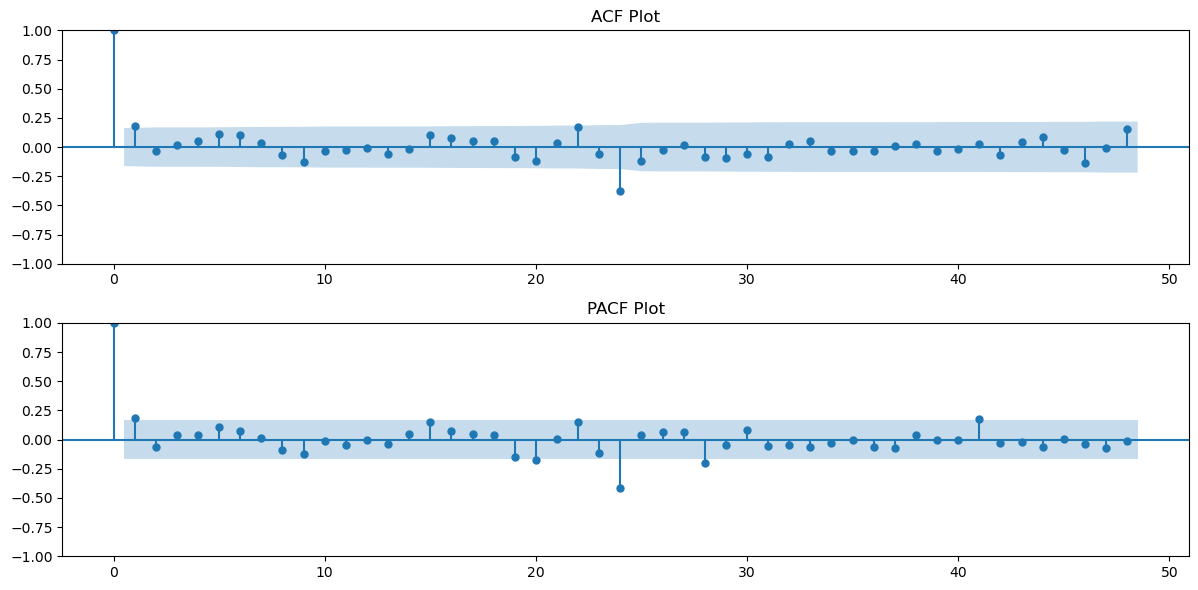

In [71]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_end_sarima.resid, lags=48, ax=plt.gca(), title="ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(results_end_sarima.resid, lags=48, ax=plt.gca(), title="PACF Plot")
plt.tight_layout()
plt.show()

# Random Forest for the Week Data

In [72]:
endog = df_april_week["Count"].reset_index()
endog = endog.drop(columns='index')

In [73]:
for diff in range(1,25,1):
    endog[f"Count{-diff}"] = endog.Count.diff(diff)
    endog.dropna(inplace=True)   
    endog.reset_index(inplace=True)     
    endog.drop(columns='index', inplace=True)

In [74]:
train_data = endog[:-48]
test_data = endog[-48:]


X_train = train_data.drop(['Count'], axis=1)
y_train = train_data['Count']

X_test = test_data.drop(['Count'], axis=1)
y_test = test_data['Count']

In [75]:



# Define the parameter grid for the grid search
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Different options for max_features
    'max_depth': [5, 10, 20, 30, 35, 40, 45],  # Different options for max_depth
    'min_samples_leaf': [1, 2, 4, 8, 10, 20]  # Different options for min_samples_leaf
}

tscv = TimeSeriesSplit(n_splits=2, test_size=48)

# Create a Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Define a custom scoring function based on RMSE
def rmse_scorer(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # We use a negative sign because GridSearchCV tries to maximize the score


# Create a GridSearchCV object with RMSE as the scoring metric
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=tscv, scoring=make_scorer(rmse_scorer), verbose=2)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best Parameters:")
print(grid_search.best_params_)

# Print the best cross-validated accuracy score
print("Best Cross-Validated Accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Set Root: {:.2f}".format(rmse))


Fitting 2 folds for each of 630 candidates, totalling 1260 fits


[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   3.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=8; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=8; total time=   0.0s
[CV] END ...max_depth=5, max_features=1, min_samples_leaf=10; total time=   0.0s
[CV] END ...max_depth=5, max_features=1, min_samples_leaf=10; total time=   0.0s
[CV] END ...max_depth=5, max_features=1, min_samples_leaf=20; total time=   0.0s
[CV] END ...max_depth=5, max_features=1, min_samples_leaf=20; total time=   0.0s
[CV] END ....max_depth=5, ma

In [76]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"Random_Forest") as run:
        train_data = endog[:-48]
        test_data = endog[-48:]


        X_train = train_data.drop(['Count'], axis=1)
        y_train = train_data['Count']

        X_test = test_data.drop(['Count'], axis=1)
        y_test = test_data['Count']
        
        # Initialize and train the Random Forest model
        rf_model = RandomForestRegressor(
            n_estimators=100,  
            max_features=11,
            max_depth=30,
            min_samples_leaf=1,
            random_state=42,  # Set a random seed for reproducibility
            n_jobs=-1  # Use all available CPU cores for parallel processing
        )
        
        rf_model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = rf_model.predict(X_train)
        y_pred_test = rf_model.predict(X_test)

        # Calculate AIC and R-squared
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # Log AIC and R-squared
        mlflow.log_metrics({
            "RMSE_Train" : rmse_train,
            "RMSE_Test" : rmse_test,
        })

        # Log the trained model
        # mlflow.sklearn.log_model(m_sarimax_24, "SARIMAX")

In [81]:
mlflow.search_runs(experiment_ids=experiment.experiment_id).sort_values(['metrics.RMSE_Test']).sort_values("metrics.RMSE_Test")

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.AIC,metrics.RMSE_Test,metrics.RMSE_Train,metrics.R-squared,...,params.seasonal_order,params.period01,params.period05,params.period02,params.period03,params.period04,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name
9,6dafad8068114cda980ed5391bc4e0ab,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:43:17.040000+00:00,2023-09-27 10:43:17.146000+00:00,1869.788842,342.960414,147.967839,0.860231,...,None,24,64,48,16,192,Max_G,LOCAL,april_harmonic_weekend,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
8,c825a4aea82944b08a3e67ea2b978fb4,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:43:18.201000+00:00,2023-09-27 10:43:24.311000+00:00,5446.424551,365.535340,124.891629,NaN,...,None,None,None,None,None,None,Max_G,LOCAL,arma_after_harmonic_regression_week,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
1,7665c084e33543c0a78ad5940b3f5d66,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:50:41.108000+00:00,2023-09-27 10:50:41.380000+00:00,NaN,378.450091,33.471873,NaN,...,None,None,None,None,None,None,Max_G,LOCAL,Random_Forest,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
2,ae8dc499ed6a491d8da7b80e99f389a3,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:48:14.839000+00:00,2023-09-27 10:48:17.720000+00:00,1450.131468,484.870944,145.589537,NaN,...,"(1, 1, 0, 24)",None,None,None,None,None,Max_G,LOCAL,"SARIMAX(3, 1, 1), (1, 1, 0, 24)_end",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
11,9e768bb051c94f83b6b968ae2a13ba6c,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:42:37.172000+00:00,2023-09-27 10:42:37.264000+00:00,6603.428204,570.838760,229.686617,0.795895,...,None,24,31.06,12,105.6,8,Max_G,LOCAL,april_harmonic_week,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
3,a3a12e37926f4dd7b0a6a8f5c1128559,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:45:03.138000+00:00,2023-09-27 10:48:13.453000+00:00,5866.013555,595.611154,143.202433,NaN,...,"(7, 1, 1, 24)",None,None,None,None,None,Max_G,LOCAL,"SARIMAX(0, 1, 6), (7, 1, 1, 24)",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
0,515c8c4076cd43e28a249411f54a410c,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 11:09:07.303000+00:00,2023-09-27 11:10:13.566000+00:00,5807.536783,632.463626,185.489892,NaN,...,"(7, 1, 0, 24)",None,None,None,None,None,Max_G,LOCAL,"SARIMAX(1, 0, 0), (7, 1, 0, 24)",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
5,fab90cebb0a543f0a121efabdb0952f2,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:43:42.602000+00:00,2023-09-27 10:44:49.795000+00:00,5807.536783,632.463626,185.489892,NaN,...,"(7, 1, 0, 24)",None,None,None,None,None,Max_G,LOCAL,"SARIMAX(1, 0, 0), (7, 1, 0, 24)",c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
7,51f01f53f75047ad84d4cef1123f4c48,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:43:25.166000+00:00,2023-09-27 10:43:38.990000+00:00,6183.555236,638.214946,140.883057,NaN,...,None,None,None,None,None,None,Max_G,LOCAL,SARIMAX,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
10,4c62cc889a294a7983b60aee8779fa8e,790551238593359977,FINISHED,file:///c:\Users\Max_G\OneDrive\IUBH\5_Semeste...,2023-09-27 10:42:37.557000+00:00,2023-09-27 10:43:16.914000+00:00,7513.500885,666.455305,137.517426,0.926836,...,None,None,None,None,None,None,Max_G,LOCAL,tbats_model_week,c:\Users\Max_G\anaconda3\lib\site-packages\ipy...
